# Advertising Channel Segmentation with K-means

**Objective**  
The goal of this project is to segment advertising channels based on performance metrics and campaign attributes using unsupervised learning.

**Approach**  
K-means clustering is applied after feature preprocessing, and PCA is used for visualization only.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [9]:
## load data
df = pd.read_csv("ad_performance.csv")
df.head()

,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点
0,A203,3.69,0.0071,0.0214,2.3071,419.77,0.0258,20,jpg,banner,roi,140*40,打折
1,A387,178.70,0.0040,0.0324,2.0489,157.94,0.0030,19,jpg,banner,cpc,140*40,满减
2,A388,91.77,0.0022,0.0530,1.8771,357.93,0.0026,4,jpg,banner,cpc,140*40,满减
3,A389,1.09,0.0074,0.3382,4.2426,364.07,0.0153,10,jpg,banner,cpc,140*40,满减
4,A390,3.37,0.0028,0.1740,2.1934,313.34,0.0007,30,jpg,banner,cpc,140*40,满减


In [11]:
## data understanding
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   渠道代号    889 non-null    object 
 1   日均UV    889 non-null    float64
 2   平均注册率   889 non-null    float64
 3   平均搜索量   889 non-null    float64
 4   访问深度    889 non-null    float64
 5   平均停留时间  887 non-null    float64
 6   订单转化率   889 non-null    float64
 7   投放总时间   889 non-null    int64  
 8   素材类型    889 non-null    object 
 9   广告类型    889 non-null    object 
 10  合作方式    889 non-null    object 
 11  广告尺寸    889 non-null    object 
 12  广告卖点    889 non-null    object 
dtypes: float64(6), int64(1), object(6)
memory usage: 90.4+ KB


,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间
count,889.000000,889.000000,889.000000,889.000000,887.000000,889.000000,889.000000
mean,540.846772,0.001408,0.030493,2.167166,262.669188,0.002852,16.052868
std,1634.410463,0.003291,0.106199,3.800528,224.364932,0.011608,8.509435
min,0.060000,0.000000,0.000000,1.000000,1.640000,0.000000,1.000000
25%,6.180000,0.000000,0.000600,1.392300,126.020000,0.000000,9.000000
50%,114.180000,0.000000,0.003200,1.793100,236.550000,0.000200,16.000000
75%,466.870000,0.001400,0.011800,2.216200,357.985000,0.002000,24.000000
max,25294.770000,0.039100,1.037000,98.979900,4450.830000,0.216500,30.000000


### Feature Selection
Numerical features represent advertising performance, 
while categorical features describe campaign characteristics.

In [21]:
NUM_COLS = ["日均UV", "平均注册率", "平均搜索量", "访问深度", "订单转化率", "投放总时间"]
CAT_COLS = ["素材类型", "广告类型", "合作方式", "广告尺寸", "广告卖点"]
df = df[NUM_COLS + CAT_COLS].dropna()
df

,日均UV,平均注册率,平均搜索量,访问深度,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点
0,3.69,0.0071,0.0214,2.3071,0.0258,20,jpg,banner,roi,140*40,打折
1,178.70,0.0040,0.0324,2.0489,0.0030,19,jpg,banner,cpc,140*40,满减
2,91.77,0.0022,0.0530,1.8771,0.0026,4,jpg,banner,cpc,140*40,满减
3,1.09,0.0074,0.3382,4.2426,0.0153,10,jpg,banner,cpc,140*40,满减
4,3.37,0.0028,0.1740,2.1934,0.0007,30,jpg,banner,cpc,140*40,满减
...,...,...,...,...,...,...,...,...,...,...,...
884,1777.75,0.0002,0.0023,1.2588,0.0002,5,swf,tips,cpc,900*120,打折
885,1953.53,0.0003,0.0026,1.1703,0.0002,16,swf,tips,cpc,900*120,打折
886,310.53,0.0002,0.0028,1.1546,0.0001,22,swf,tips,cpc,900*120,打折
887,1370.38,0.0001,0.0016,1.3939,0.0001,10,swf,tips,cpd,900*120,打折


In [56]:
preprocess=ColumnTransformer([
    ("num",MinMaxScaler(),NUM_COLS),
    ("cat",OneHotEncoder (handle_unknown="ignore"),CAT_COLS)])

X = preprocess.fit_transform(df)
# preprocess对象 
# 执行 fit(df) 后：
# ├── 规则1：数值列 → MinMaxScaler
# │   ├── 日均UV：最小值=100，最大值=300
# │   └── 平均注册率：最小值=0.03，最大值=0.08
# ├── 规则2：分类列 → OneHotEncoder
# │   └── 素材类型：['gif', 'jpg', 'png']（按字母排序）
# 执行 transform(df) 时：
# 输入：日均UV=150，平均注册率=0.06，素材类型='jpg'
# 应用规则：
# 1. 日均UV → (150-100)/(300-100) = 0.25
# 2. 平均注册率 → (0.06-0.03)/(0.08-0.03) = 0.6  
# 3. 素材类型='jpg' → 位置1 → [0, 1, 0]
# 输出：[0.25, 0.6, 0, 1, 0]

X.shape

(889, 33)

In [62]:
scores = {}
for k in range(2, 8):
    labels = KMeans(n_clusters=k, random_state=42, n_init="auto").fit_predict(X)
    scores[k] = silhouette_score(X, labels)
scores


D:\Anodaote\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
D:\Anodaote\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
D:\Anodaote\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
D:\Anodaote\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

{2: 0.3865549293769709,
 3: 0.4584107313567129,
 4: 0.45065548742200245,
 5: 0.49653988898338547,
 6: 0.47034671845907106,
 7: 0.4853920227075372}

In [64]:
best_k = max(scores, key=scores.get)
df["cluster"] = KMeans(
    n_clusters=best_k, random_state=42, n_init="auto"
).fit_predict(X)


D:\Anodaote\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [66]:
df.groupby("cluster")[NUM_COLS].mean()

,日均UV,平均注册率,平均搜索量,访问深度,订单转化率,投放总时间
cluster,,,,,,
0,572.521054,0.001182,0.051364,2.144642,0.003868,17.124601
1,236.079879,0.000779,0.016575,2.335185,0.001355,15.334677
2,613.835779,0.002649,0.020118,2.189583,0.003309,15.681818
3,457.662178,0.001886,0.013827,2.108242,0.002950,15.386139
4,1401.524521,0.001229,0.033232,1.727166,0.002475,15.602740


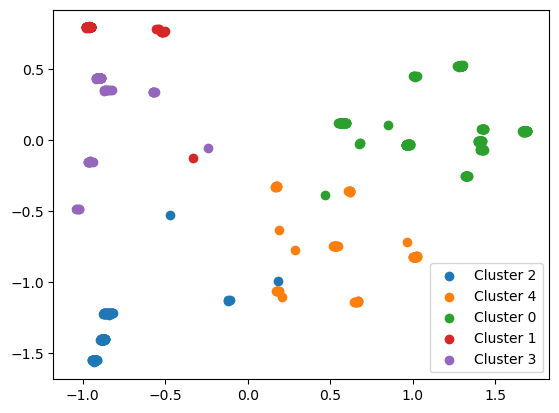

In [68]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

df["PC1"] = X_pca[:, 0]
df["PC2"] = X_pca[:, 1]

for c in df["cluster"].unique():
    sub = df[df["cluster"] == c]
    plt.scatter(sub["PC1"], sub["PC2"], label=f"Cluster {c}")

plt.legend()
plt.show()


The PCA plot shows that the clusters are generally well separated.
The first principal component (PC1) divides the clusters into groups with different overall characteristics.
The second principal component (PC2) further differentiates clusters based on secondary differences.
Although some overlap exists, most clusters remain distinguishable, supporting the robustness of the clustering results.

In [96]:
# 用英文名，避免中文字体问题（项目中这是加分项）
feature_map = {
    "日均UV": "Avg_UV",
    "平均注册率": "Reg_Rate",
    "平均搜索量": "Search_Vol",
    "访问深度": "Visit_Depth",
    "订单转化率": "Conv_Rate",
    "投放总时间": "Ad_Time"
}

df_english = df.rename(columns=feature_map)
NUM_COLS_EN = list(feature_map.values())


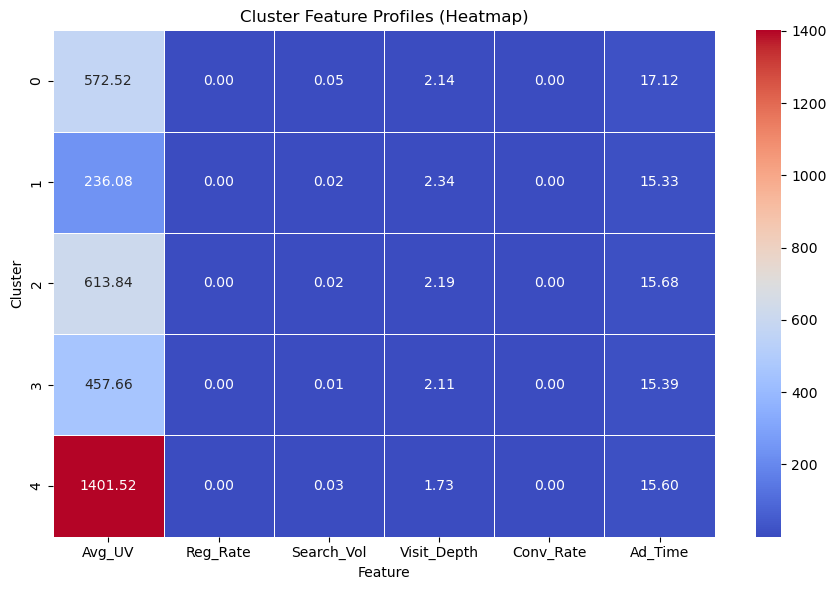

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

# 计算 cluster 均值
cluster_means = df_english.groupby("cluster")[NUM_COLS_EN].mean()

plt.figure(figsize=(9, 6))
sns.heatmap(
    cluster_means,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    linewidths=0.5
)

plt.title("Cluster Feature Profiles (Heatmap)")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()



## Cluster-Level Interpretation and Media Buying Scenarios

The following analysis is based on cluster-level mean feature values visualized in the heatmap.  
Each cluster represents a distinct type of advertising channel with different performance characteristics and suitable use cases.

---

### Cluster 0 — Medium Traffic, Moderate Engagement, Weak Conversion

**Profile**
- Medium average traffic volume (Avg_UV)
- Moderate user engagement (Visit_Depth)
- Very low registration and conversion rates

**Interpretation**  
Cluster 0 consists of channels that can attract a reasonable amount of traffic and keep users browsing, but fail to convert engagement into meaningful actions such as registration or purchase.

**Suitable Scenarios**
- Brand awareness campaigns  
- Top-of-funnel exposure  
- Early-stage user education and content promotion  

**Recommendation**  
These channels are suitable for warming up traffic rather than direct ROI-driven campaigns. Conversion-related elements (landing pages, call-to-action design, audience targeting) should be optimized before increasing investment.

---

### Cluster 1 — Low Traffic, High Engagement, Small Scale

**Profile**
- Low traffic volume
- Relatively high visit depth
- Low conversion rates

**Interpretation**  
Cluster 1 represents low-volume but high-quality traffic. Users who reach these channels tend to explore content more deeply, suggesting higher interest or intent, despite the limited scale.

**Suitable Scenarios**
- Niche audience targeting  
- Content-driven or educational campaigns  
- Pilot tests for new creatives or messaging strategies  

**Recommendation**  
This cluster is well suited for quality-focused initiatives and A/B testing. Although scaling potential is limited, insights gained here can be applied to improve performance in other clusters.

---

### Cluster 2 — Balanced Performance with No Clear Strength

**Profile**
- Medium-to-high traffic volume
- Moderate engagement
- Slightly higher search activity compared to other clusters
- Weak conversion performance

**Interpretation**  
Cluster 2 shows a balanced but unspecialized performance profile. No single metric stands out, indicating stable but non-differentiated channels.

**Suitable Scenarios**
- Always-on campaigns  
- Baseline traffic acquisition  
- Supporting role in multi-channel strategies  

**Recommendation**  
These channels can function as a stable backbone of media spending. Incremental optimization may improve results, but they are not ideal for aggressive growth or conversion-focused objectives.

---

### Cluster 3 — Moderate Traffic, Overall Weak Performance

**Profile**
- Medium traffic volume
- Lower engagement
- Lowest overall performance across most metrics

**Interpretation**  
Cluster 3 represents underperforming channels with limited user engagement and weak conversion intent. These channels show no clear advantage in either scale or quality.

**Suitable Scenarios**
- Low-priority placements  
- Budget-constrained campaigns  
- Experimental or clearance inventory  

**Recommendation**  
Investment in this cluster should be strictly controlled. Channels in this group may be paused or deprioritized unless specific improvement opportunities are identified.

---

### Cluster 4 — High Traffic, Low-Quality Engagement

**Profile**
- Highest traffic volume by a large margin
- Shallow user engagement (lowest visit depth)
- Low conversion rates

**Interpretation**  
Cluster 4 is characterized by very high exposure but poor traffic quality. Users arrive in large numbers but disengage quickly, indicating low intent.

**Suitable Scenarios**
- Large-scale brand exposure  
- Awareness campaigns with reach-focused objectives  
- Short-term visibility boosts  

**Recommendation**  
These channels are appropriate for reach-driven goals rather than performance marketing. Budget allocation should be carefully monitored, and audience filtering or creative refinement is strongly recommended to avoid inefficient spending.

---

## Overall Strategic Insight

Overall, the clustering results indicate that advertising channels differ primarily in traffic scale and engagement patterns, while conversion efficiency remains consistently low across all clusters.  
This suggests that future optimization efforts should prioritize improving conversion funnels rather than merely increasing traffic volume.  
Assigning distinct strategic roles to different clusters can help align media investments with campaign objectives and improve overall efficiency.
